### Building noise models using Qiskit

##### Dr. Ritajit Majumdar, Research Scientist, IBM Quantum

In [3]:
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)
from qiskit_aer import AerSimulator

#### Pauli X, Y and Z errors


In [4]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([("X", p_error), ("I", 1 - p_error)])
phase_flip = pauli_error([("Z", p_error), ("I", 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [5]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


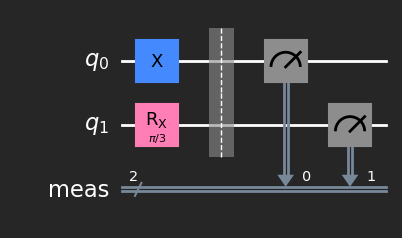

In [7]:
from qiskit import QuantumCircuit
import numpy as np

qc = QuantumCircuit(2)
qc.x(0)
qc.rx(np.pi/3,1)
qc.measure_all()
qc.draw('mpl', style='iqp-dark')

In [10]:
from qiskit.visualization import plot_histogram

ideal_simulator = AerSimulator()
ideal_result = ideal_simulator.run(qc).result()
ideal_counts = ideal_result.get_counts()


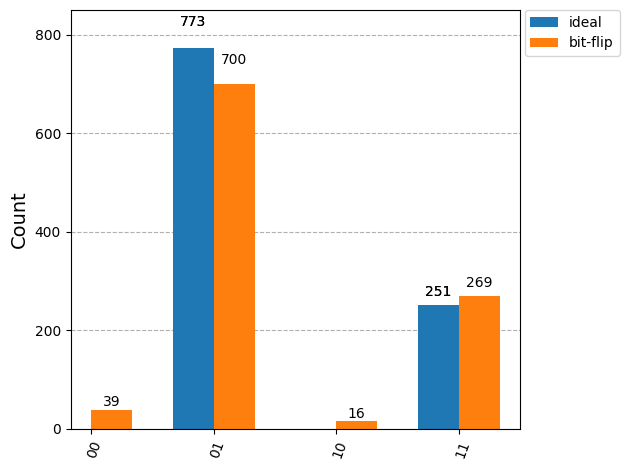

In [19]:
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(bit_flip, ['x','rx'])
bit_flip_simulator = AerSimulator(noise_model=noise_model)
bit_flip_result = bit_flip_simulator.run(qc).result()
bit_flip_counts = bit_flip_result.get_counts()
plot_histogram([ideal_counts, bit_flip_counts], legend=['ideal', 'bit-flip'])

In order to apply the noise model on

- only 'x' gate (say), noise_model.add_all_qubit_quantum_error(bit_flip, ['x'])
- only 1st qubit (say), noise_model.add_quantum_error(bit_flip, ['x','rx'], [0])

In [29]:
## Combining noise models
combined_noise_model = bit_flip.tensor(phase_flip)
print(combined_noise_model)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ Z ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ Z ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


#### Depolarizing noise

In [40]:
depol_noise = [depolarizing_error(p_error, 1) for p_error in [0.05, 0.1, 0.3, 0.5]]
print(depol_noise[0])


QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.9625, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
  P(1) = 0.0125, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(2) = 0.0125, Circuit = 
   ┌───┐
q: ┤ Y ├
   └───┘
  P(3) = 0.0125, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘


In [41]:
depol_noise_models = []
for i in range(len(depol_noise)):
    noise_depol = NoiseModel()
    noise_depol.add_all_qubit_quantum_error(depol_noise[i], ['x','rx'])
    depol_noise_models.append(noise_depol)

In [42]:
depol_noise_models[0]

<NoiseModel on ['rx', 'x']>

In [43]:
counts_depol = []
for i in range(len(depol_noise_models)):
    depol_simulator = AerSimulator(noise_model=depol_noise_models[i])
    depol_result = depol_simulator.run(qc).result()
    depol_counts = depol_result.get_counts()
    counts_depol.append(depol_counts)

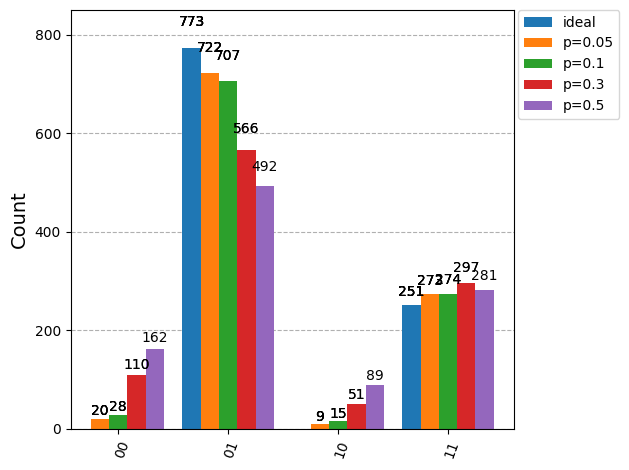

In [45]:
plot_histogram([ideal_counts] + counts_depol, legend=['ideal'] + [f'p={p}' for p in [0.05, 0.1, 0.3, 0.5]])


#### Kraus Operators

One can convert a particular noise model to a Kraus operator

In [50]:
from qiskit.quantum_info import Kraus
kraus_depol = Kraus(depol_noise[0])
print(kraus_depol)

Kraus([[[-0.98107084+0.j,  0.        +0.j],
        [ 0.        +0.j, -0.98107084+0.j]],

       [[-0.1118034 +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.1118034 +0.j]],

       [[ 0.        +0.j,  0.        +0.j],
        [ 0.15811388+0.j,  0.        +0.j]],

       [[ 0.        +0.j,  0.15811388+0.j],
        [ 0.        +0.j,  0.        +0.j]]],
      input_dims=(2,), output_dims=(2,))


We can even convert a Kraus operator to a quantum channel. Recall the Kraus operators for state preparation, i.e. map any quantum system to the state $|0\rangle$

$K_0 = |0\rangle \langle 0|$, $K_1 = |0\rangle \langle 1|$

In [97]:
zero = np.array([[1, 0], [0, 0]])
one = np.array([[0, 0], [1, 0]])
K0 = np.matmul(zero, np.transpose(zero))
K1 = np.matmul(zero, np.transpose(one))
print(f'K0:{K0}')
print(f'K1:{K1}')


K0:[[1 0]
 [0 0]]
K1:[[0 1]
 [0 0]]


In [98]:
sp_kraus = Kraus([K0, K1])
print(sp_kraus)

Kraus([[[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [105]:
sp_kraus.is_unitary()

False

In [106]:
sp_kraus.is_cptp()

True

#### Measurement error

In [57]:
# Measurement misassignment probabilities
p0g1 = 0.1
p1g0 = 0.05
 
roerror = ReadoutError([[1 - p1g0, p1g0], [p0g1, 1 - p0g1]])
print(roerror)

ReadoutError on 1 qubits. Assignment probabilities:
 P(j|0) =  [0.95 0.05]
 P(j|1) =  [0.1 0.9]


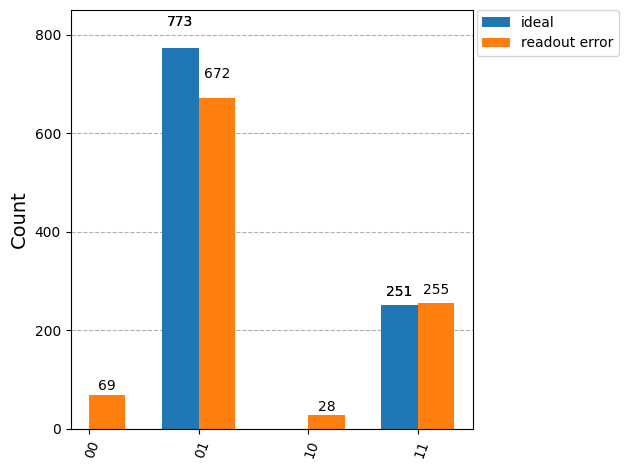

In [58]:
ro_noise_model = NoiseModel()
ro_noise_model.add_all_qubit_readout_error(roerror)
ro_simulator = AerSimulator(noise_model=ro_noise_model)
ro_result = ro_simulator.run(qc).result()

ro_counts = ro_result.get_counts()
plot_histogram([ideal_counts, ro_counts], legend=['ideal', 'readout error'])

- Q: Why does this outcome look so similar to when we applied bit flip error?
- A: Because readout error can be modelled as a bit flip before the measurement. In the bit flip example, the gate was noisy, but the measurement was ideal. We can consider it as an ideal gate followed by a noise channel before measurement. So these two cases are equivalent.

#### Thermal relaxation

In [80]:
# taking the median T1 and T2 values of ibm_pittsburgh
T1 = 296730
T2 = 352000

# dividing T1 and T2 values by 100 to show the impact of noise more clearly
T1_new = T1 / 100
T2_new = T2 / 100

# taking the median time for a single qubit gate and measurement
time_gate = 32
time_meas = 2584

In [81]:
error_gate = thermal_relaxation_error(T1, T2, time_gate)
error_meas = thermal_relaxation_error(T1, T2, time_meas)
print(error_gate)
print(error_meas)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


In [82]:
noise_thermal = NoiseModel()
noise_thermal.add_all_qubit_quantum_error(error_gate, ['x','rx'])
noise_thermal.add_all_qubit_quantum_error(error_meas, ['measure'])
print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rx', 'rz', 'sx', 'x']
  Instructions with noise: ['rx', 'x', 'measure']
  All-qubits errors: ['x', 'rx', 'measure']


In [83]:
error_gate_new = thermal_relaxation_error(T1_new, T2_new, time_gate)
error_meas_new = thermal_relaxation_error(T1_new, T2_new, time_meas)

noise_thermal_new = NoiseModel()
noise_thermal_new.add_all_qubit_quantum_error(error_gate_new, ['x','rx'])
noise_thermal_new.add_all_qubit_quantum_error(error_meas_new, ['measure'])
print(noise_thermal_new)

NoiseModel:
  Basis gates: ['cx', 'id', 'rx', 'rz', 'sx', 'x']
  Instructions with noise: ['rx', 'x', 'measure']
  All-qubits errors: ['x', 'rx', 'measure']


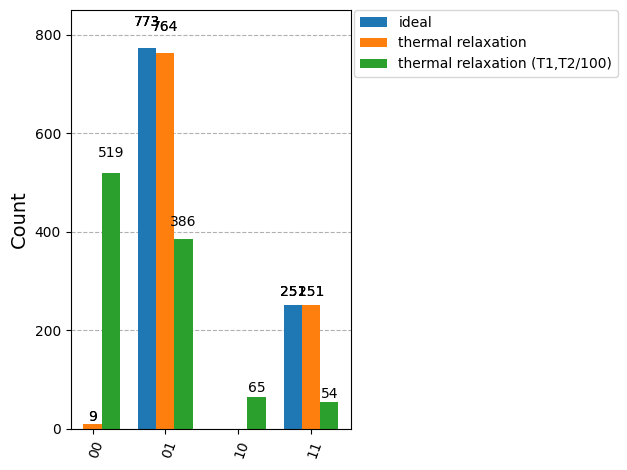

In [84]:
thermal_simulator = AerSimulator(noise_model=noise_thermal)
thermal_result = thermal_simulator.run(qc).result()
thermal_counts = thermal_result.get_counts()

thermal_simulator_new = AerSimulator(noise_model=noise_thermal_new)
thermal_result_new = thermal_simulator_new.run(qc).result()
thermal_counts_new = thermal_result_new.get_counts()
plot_histogram([ideal_counts, thermal_counts, thermal_counts_new], legend=['ideal', 'thermal relaxation', 'thermal relaxation (T1,T2/100)'])

Note how the distribution moves towards all zero as the T1, T2 times are lowered. It shows the relaxation effect more clearly.

#### A complete noise model

In [86]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(min_num_qubits=127, simulator=False)

In [89]:
noise_model_from_backend = NoiseModel.from_backend(backend)
print(noise_model_from_backend)

NoiseModel:
  Basis gates: ['cz', 'delay', 'id', 'if_else', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'cz', 'id', 'x', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('rese

In order to apply this noise model, we first need to ensure that all gates are in the basis gate set. We can do that by transpilation.

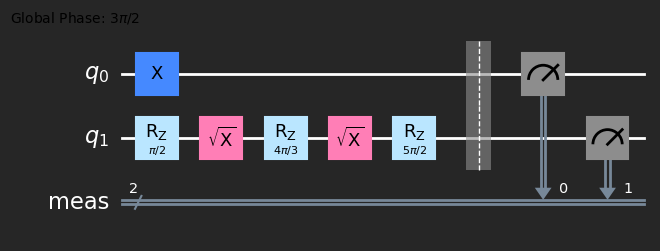

In [90]:
from qiskit.transpiler import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=1, basis_gates=noise_model_from_backend.basis_gates)
isa_qc = pm.run(qc)
isa_qc.draw('mpl', style='iqp-dark')


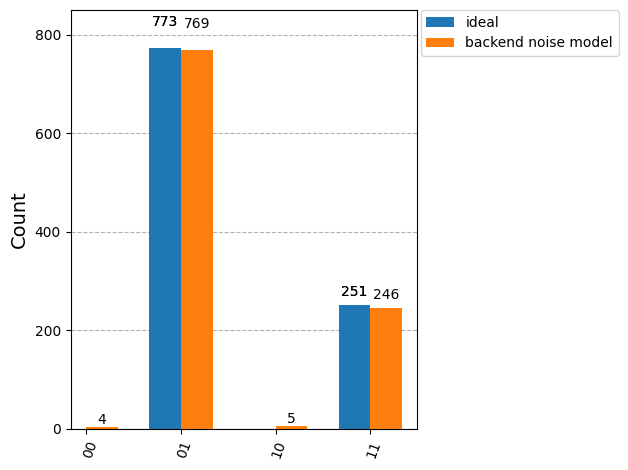

In [91]:
backend_simulator = AerSimulator(noise_model=noise_model_from_backend)
backend_result = backend_simulator.run(isa_qc).result()
backend_counts = backend_result.get_counts()
plot_histogram([ideal_counts, backend_counts], legend=['ideal', 'backend noise model'])

Note that the same effect could have been obtained by transpiling the circuit on the backend and executing on the real hardware (or FakeBackend for smaller circuits).